# MoE v/s Hyper-MoE on IRIS

## Imports

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

## Define MLP, HyperNetwork, and MoE models

In [2]:
class MLP(nn.Module):
    def __init__(self, input_dim, intermediate_dims, output_dim):
        super().__init__()
        self.input_dim = input_dim
        self.intermediate_dims = intermediate_dims # list of ints
        self.output_dim = output_dim
        self.num_layers = len(intermediate_dims) + 1

        self.layers = []
        current_dim = input_dim
        next_dims = intermediate_dims + [output_dim]

        for i in range(self.num_layers):
            self.layers.append(nn.Linear(current_dim, next_dims[i]))
            current_dim = next_dims[i]

            if i != self.num_layers - 1:
                self.layers.append(nn.GELU())

        self.layers = nn.ModuleList(self.layers)

    def forward(self, x, multi_stage=False):
        out = []
        if multi_stage:
            for layer in self.layers:
                x = layer(x)
                out.append(x)
        else:
            for layer in self.layers:
                x = layer(x)
            out = x

        return out


class HyperNetwork(nn.Module):
    def __init__(self, param_shapes, cond_emb_dim, num_conds, expansion_factor=4):
        """
        param_shapes: if the target network has N layers then
        [
            [ [w_1.shape[0], w_1.shape[1]], [b_1.shape[0]] ] --> layer 1
            ...
            [ [w_N.shape[0], w_N.shape[1]], [b_N.shape[0]] ] --> layer N
        ]
        """
        super().__init__()
        self.param_shapes = param_shapes
        self.cond_embs = nn.Embedding(num_conds, cond_emb_dim)
        self.expansion_factor = expansion_factor

        self.num_target_layers = len(param_shapes)
        self.cond_mapper = MLP(cond_emb_dim, [expansion_factor * cond_emb_dim for _ in range(self.num_target_layers-1)], expansion_factor*cond_emb_dim)

        self.weight_decoders = []
        self.bias_decoders = []

        for i in range(self.num_target_layers):
            output_param_shape = param_shapes[i][0][0] * param_shapes[i][0][1]
            decoder = nn.Linear(expansion_factor*cond_emb_dim, output_param_shape)
            self.weight_decoders.append(decoder)

            output_param_shape = param_shapes[i][1][0]
            decoder = nn.Linear(expansion_factor*cond_emb_dim, output_param_shape)
            self.bias_decoders.append(decoder)

        self.weight_decoders = nn.ModuleList(self.weight_decoders)
        self.bias_decoders = nn.ModuleList(self.bias_decoders)

    def forward(self, cond_ids):
        num_conds = len(cond_ids)
        cond_ids = torch.tensor(cond_ids).long()
        cond_embs = self.cond_embs(cond_ids)
        cond_embs_mapped = self.cond_mapper(cond_embs, multi_stage=True)

        weights, biases = [], []
        for i in range(self.num_target_layers):
            weights.append(self.weight_decoders[i](cond_embs_mapped[i]))
            biases.append(self.bias_decoders[i](cond_embs_mapped[i]))

        params = [ [weights[i].view(num_conds, *self.param_shapes[i][0]), biases[i]] for i in range(len(weights)) ]
        return params


In [3]:
class IrisMoE(nn.Module):
    def __init__(self):
        super().__init__()
        self.experts = nn.ModuleList([MLP(1, [64], 3) for _ in range(4)])
        self.out_proj = nn.Linear(12, 3)
    
    def forward(self, x):
        out = [self.experts[i](x[:, i].unsqueeze(-1)) for i in range(4)]
        out = torch.cat(out, dim=1)
        out = F.gelu(out)
        return self.out_proj(out)
    

class HyperMoE(nn.Module):
    def __init__(self):
        super().__init__()
        self.param_shapes = [
            [[1, 64], [64]],
            [[64, 3], [3]]
        ]
        self.hypernetwork = HyperNetwork(self.param_shapes, 8, 4)
        self.out_proj = nn.Linear(12, 3)

    def params_to_models(self, params):
        models = []
        for i in range(params[0][0].shape[0]): # num conds
            model_func = lambda x: (F.gelu(x @ params[0][0][i]) + params[0][1][i]) @ params[1][0][i] + params[1][1][i]
            models.append(model_func)
        
        return models

    def forward(self, x):
        params = self.hypernetwork([0, 1, 2, 3])
        out = [model(x[:, i].unsqueeze(-1)) for i, model in enumerate(self.params_to_models(params))]
        out = torch.cat(out, dim=1)
        out = F.gelu(out)
        return self.out_proj(out)
            

## Load IRIS

In [4]:
iris = load_iris()
X = iris.data
y = iris.target

(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.2, random_state=42)

## MoEs (normal)

Partition the input space by feature

=> 4 experts (2-layer MLPs) for each feature.

Result found for the best learning rate on full-batch SGD.

1331


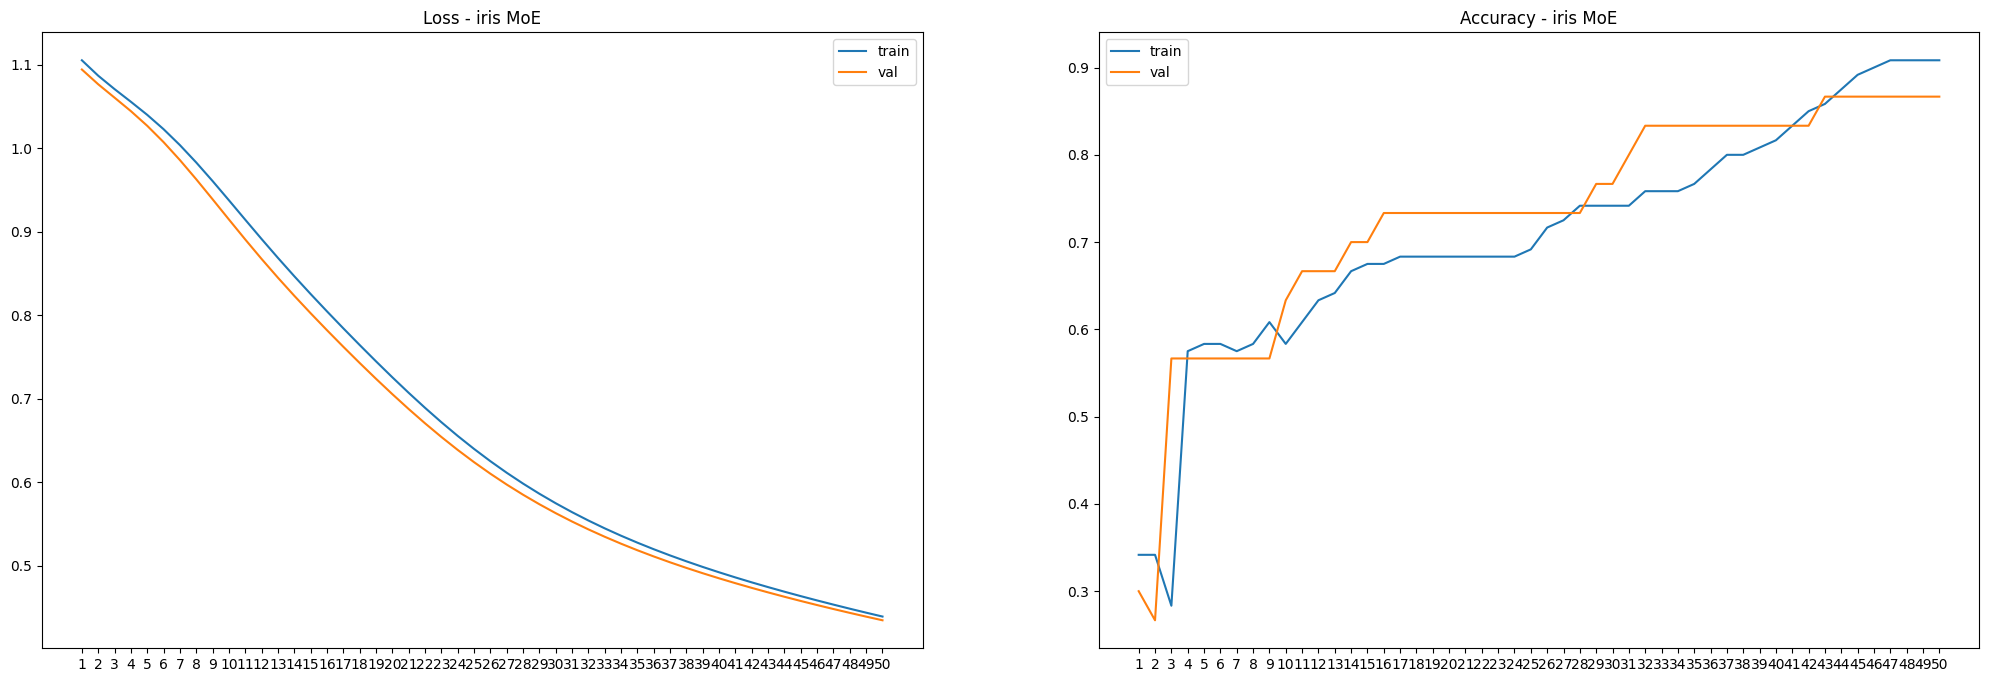

['layers.0.weight', 'layers.0.bias', 'layers.2.weight', 'layers.2.bias']
torch.Size([4, 323])


In [24]:
torch.manual_seed(0)
model = IrisMoE()

c = 0
for p in model.parameters():
    c += p.numel()

print(c)

num_epochs = 50

train_data = torch.from_numpy(X_train).float()
train_labels = torch.from_numpy(y_train).long()

val_data = torch.from_numpy(X_test).float()
val_labels = torch.from_numpy(y_test).long()

optimizer = torch.optim.SGD(model.parameters(), lr=4e-2)

store = {
    "train": {
        "loss": [],
        "accuracy": []
    },
    "val": {
        "loss": [],
        "accuracy": []
    }
}

for epoch in range(num_epochs):
    optimizer.zero_grad()

    model.train()
    train_preds = model(train_data)
    train_loss = F.cross_entropy(train_preds, train_labels)
    train_accuracy = (train_preds.argmax(dim=1) == train_labels).float().mean()

    train_loss.backward()
    optimizer.step()

    model.eval()
    val_preds = model(val_data)
    val_loss = F.cross_entropy(val_preds, val_labels)
    val_accuracy = (val_preds.argmax(dim=1) == val_labels).float().mean()


    store["train"]["loss"].append(train_loss.item())
    store["train"]["accuracy"].append(train_accuracy.item())

    store["val"]["loss"].append(val_loss.item())
    store["val"]["accuracy"].append(val_accuracy.item())

# torch.save(model.state_dict(), f"iris_moe_0.pt")

epochs = [i for i in range(1, num_epochs+1)]
fig, axes = plt.subplots(1, 2, figsize=(25, 8))
axes[0].plot(epochs, store["train"]["loss"], label="train")
axes[0].plot(epochs, store["val"]["loss"], label="val")
axes[0].legend()
axes[0].set_xticks(epochs)
axes[0].set_title(f"Loss - iris MoE")

axes[1].plot(epochs, store["train"]["accuracy"], label="train")
axes[1].plot(epochs, store["val"]["accuracy"], label="val")
axes[1].legend()
axes[1].set_xticks(epochs)
axes[1].set_title(f"Accuracy - iris MoE")

plt.show()

names = [n for n,p in model.experts[0].named_parameters()]
print(names)
moe_expert_params = [torch.cat([p.flatten() for p in expert.parameters()], dim=0).unsqueeze(0) for expert in model.experts]
moe_expert_params = torch.cat(moe_expert_params, dim=0)
print(moe_expert_params.shape)


## Hyper MoEs

Same MoE setup (1 expert per feature) but experts are predicted instead of learnt.

Result found for the best learning rate on full-batch SGD.

12074


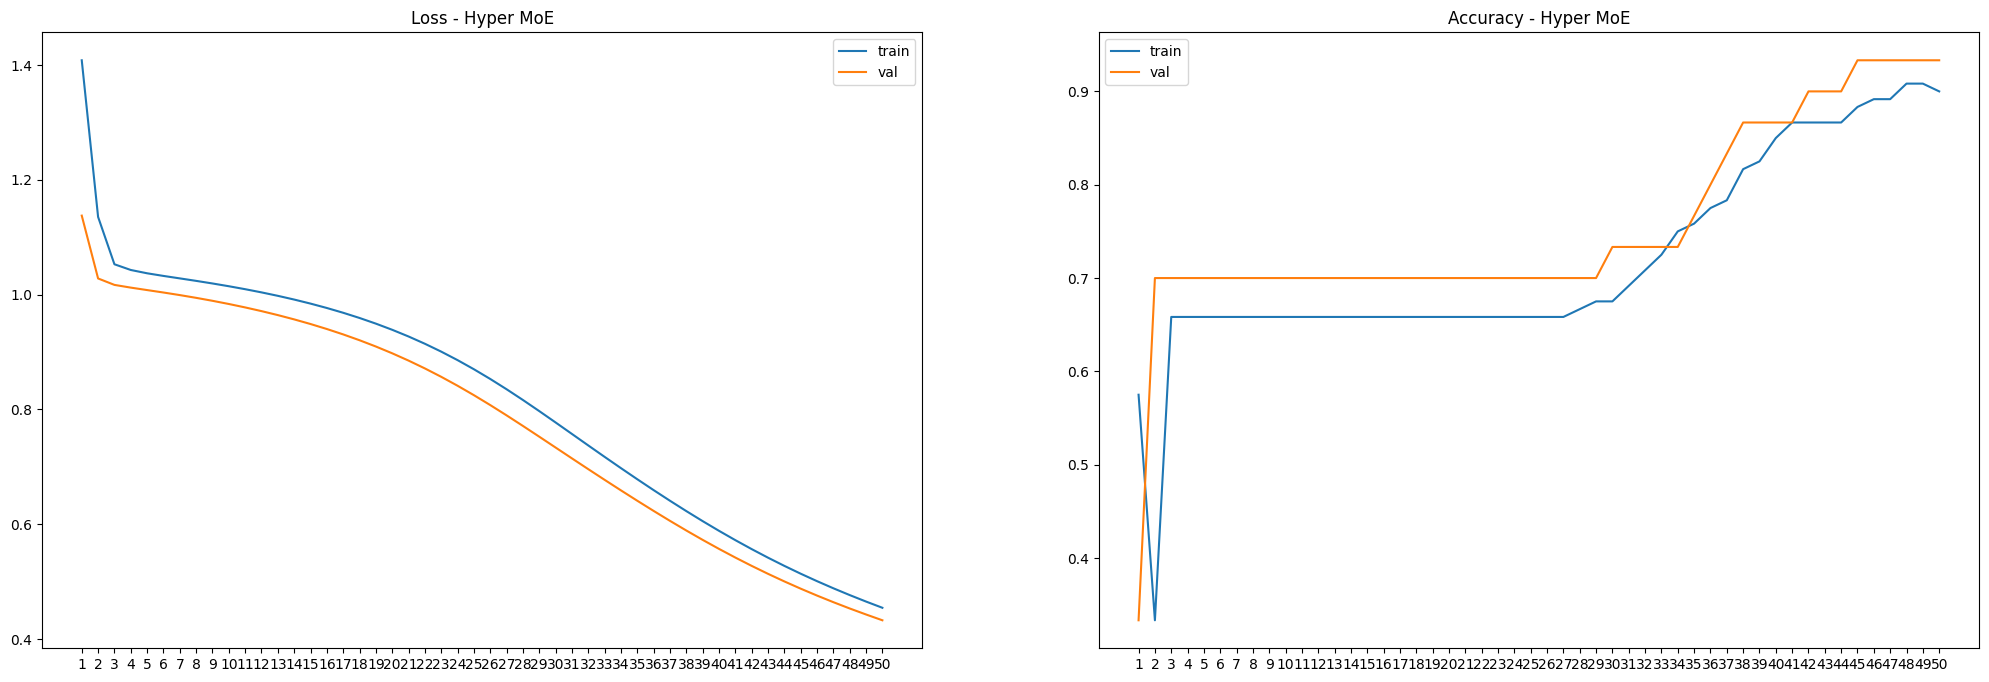

torch.Size([4, 323])


In [25]:
torch.manual_seed(0)
model = HyperMoE()

c = 0
for p in model.parameters():
    c += p.numel()

print(c)
num_epochs = 50

train_data = torch.from_numpy(X_train).float()
train_labels = torch.from_numpy(y_train).long()

val_data = torch.from_numpy(X_test).float()
val_labels = torch.from_numpy(y_test).long()

optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

hstore = {
    "train": {
        "loss": [],
        "accuracy": []
    },
    "val": {
        "loss": [],
        "accuracy": []
    }
}

for epoch in range(num_epochs):
    optimizer.zero_grad()

    model.train()
    train_preds = model(train_data)
    train_loss = F.cross_entropy(train_preds, train_labels)
    train_accuracy = (train_preds.argmax(dim=1) == train_labels).float().mean()

    train_loss.backward()
    optimizer.step()

    model.eval()
    val_preds = model(val_data)
    val_loss = F.cross_entropy(val_preds, val_labels)
    val_accuracy = (val_preds.argmax(dim=1) == val_labels).float().mean()


    hstore["train"]["loss"].append(train_loss.item())
    hstore["train"]["accuracy"].append(train_accuracy.item())

    hstore["val"]["loss"].append(val_loss.item())
    hstore["val"]["accuracy"].append(val_accuracy.item())

# torch.save(model.state_dict(), f"iris_moe_0.pt")

epochs = [i for i in range(1, num_epochs+1)]
fig, axes = plt.subplots(1, 2, figsize=(25, 8))
axes[0].plot(epochs, hstore["train"]["loss"], label="train")
axes[0].plot(epochs, hstore["val"]["loss"], label="val")
axes[0].legend()
axes[0].set_xticks(epochs)
axes[0].set_title(f"Loss - Hyper MoE")

axes[1].plot(epochs, hstore["train"]["accuracy"], label="train")
axes[1].plot(epochs, hstore["val"]["accuracy"], label="val")
axes[1].legend()
axes[1].set_xticks(epochs)
axes[1].set_title(f"Accuracy - Hyper MoE")

plt.show()

params = model.hypernetwork([0, 1, 2, 3])
hypermoe_expert_params = []
for i in range(4):
    expert_params = [
        params[0][0][i].T.flatten(),
        params[0][1][i].flatten(),
        params[1][0][i].T.flatten(),
        params[1][1][i].flatten()
    ]
    expert_params = torch.cat(expert_params, dim=0)
    hypermoe_expert_params.append(expert_params.unsqueeze(0))
hypermoe_expert_params = torch.cat(hypermoe_expert_params, dim=0)
print(hypermoe_expert_params.shape)


### Normal v/s Hyper MoE: Val accuracy

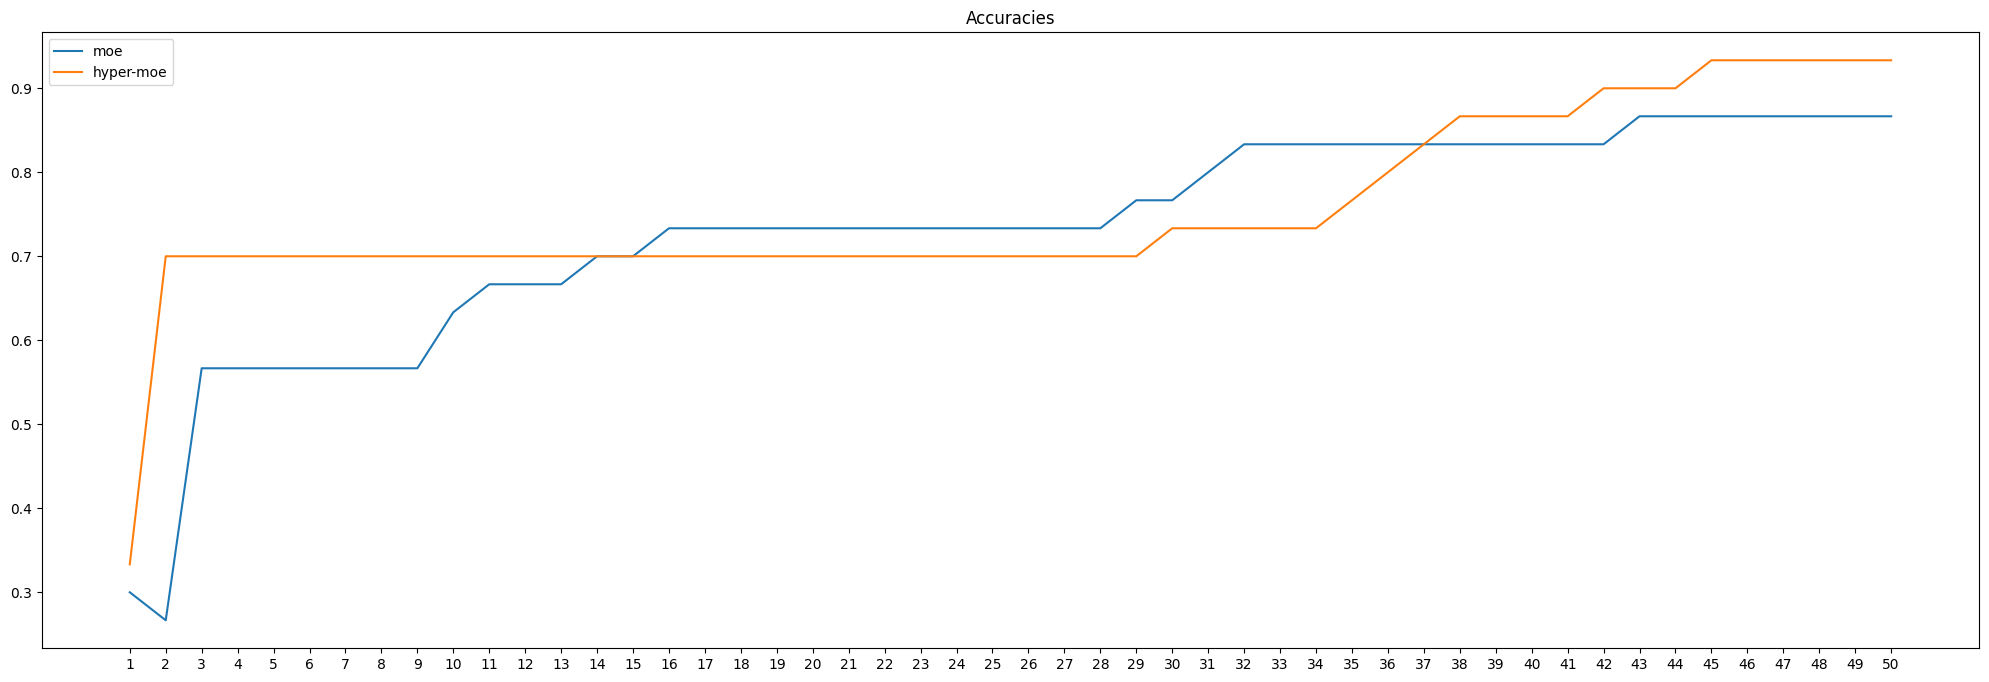

In [7]:
plt.figure(figsize=(25,8))
plt.plot(epochs, store["val"]["accuracy"], label="moe")
plt.plot(epochs, hstore["val"]["accuracy"], label="hyper-moe")
plt.legend()
plt.xticks(epochs)
plt.title("Accuracies")
plt.show()

### Normal v/s Hyper MoE: Val loss

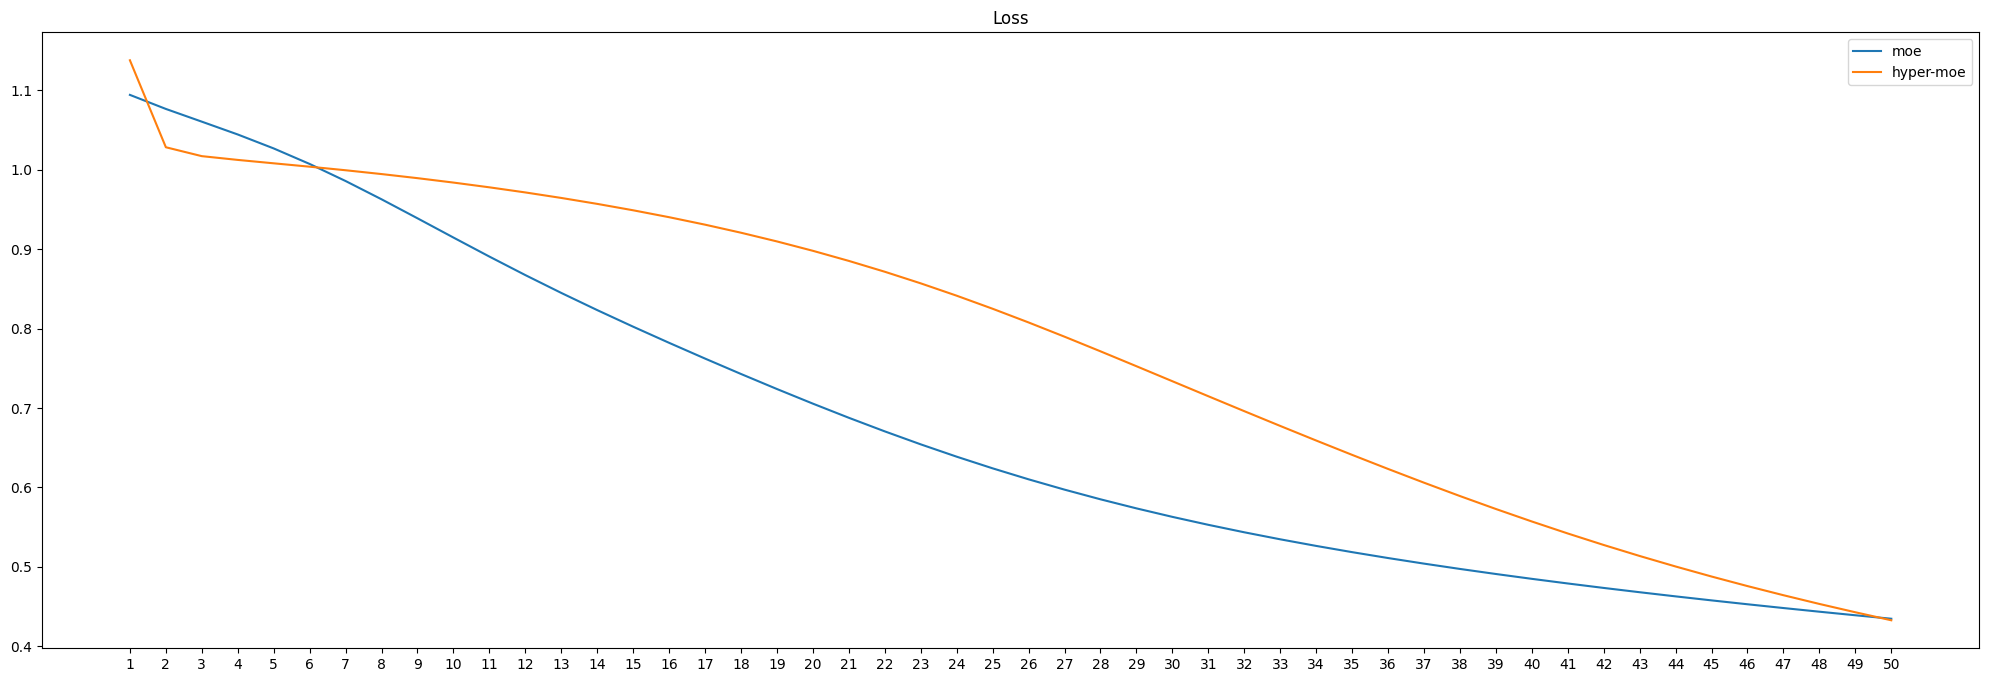

In [8]:
plt.figure(figsize=(25,8))
plt.plot(epochs, store["val"]["loss"], label="moe")
plt.plot(epochs, hstore["val"]["loss"], label="hyper-moe")
plt.legend()
plt.xticks(epochs)
plt.title("Loss")
plt.show()

## Variance among expert weights

In [26]:
print(f"Norm of the variance of the flattened weights of normal experts:") 
print(moe_expert_params.var(dim=0).norm())
print(" ")
print(f"Norm of the variance of the flattened weights of hyper-moe experts:") 
print(hypermoe_expert_params.var(dim=0).norm())
print(" ")
print(f"Average variance of normal experts:")
print(moe_expert_params.var(dim=0).mean())
print(" ")
print(f"Average variance of hyper-moe experts:")
print(hypermoe_expert_params.var(dim=0).mean())

Norm of the variance of the flattened weights of normal experts:
tensor(4.6496, grad_fn=<LinalgVectorNormBackward0>)
 
Norm of the variance of the flattened weights of hyper-moe experts:
tensor(1.2528, grad_fn=<LinalgVectorNormBackward0>)
 
Average variance of normal experts:
tensor(0.1436, grad_fn=<MeanBackward0>)
 
Average variance of hyper-moe experts:
tensor(0.0431, grad_fn=<MeanBackward0>)


Since the variance in normal MoE experts is higher than those of Hyper-MoE, it suggests than normal MoE experts are more distinct from each other (potentially more specialisation).

In [27]:
moe_expert_params = moe_expert_params.detach().numpy()
hypermoe_expert_params = hypermoe_expert_params.detach().numpy()

## Mutual information between experts

In [48]:
from sklearn.metrics import mutual_info_score

def compute_mutual_information(x, y, bins=20):
    """
    Compute the mutual information between two D-dimensional vectors using histograms.
    
    Args:
        x (np.ndarray): First vector, shape (D,).
        y (np.ndarray): Second vector, shape (D,).
        bins (int): Number of bins for discretization.

    Returns:
        float: Mutual information between x and y.
    """
    # Discretize the input vectors using histograms
    x_binned = np.digitize(x, bins=np.histogram_bin_edges(x, bins=bins))
    y_binned = np.digitize(y, bins=np.histogram_bin_edges(y, bins=bins))
    
    # Compute mutual information using sklearn's mutual_info_score
    mi = mutual_info_score(x_binned, y_binned)
    return mi

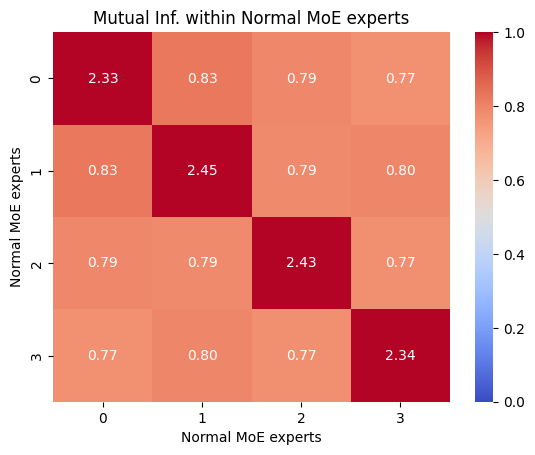

In [70]:
moe_intra_mi = np.zeros((4,4))
for i in range(4):
    for j in range(4):
        moe_intra_mi[i][j] = compute_mutual_information(moe_expert_params[i].flatten(), moe_expert_params[j].flatten()) 

sns.heatmap(moe_intra_mi, annot=True, fmt=".2f", cmap="coolwarm", vmin=0, vmax=1, center=0.5)
plt.ylabel("Normal MoE experts")
plt.xlabel("Normal MoE experts")
plt.title("Mutual Inf. within Normal MoE experts")
plt.show()


Normal MoE experts share (ignore self-MI) a roughly constant amount of MI

=> Roughly, the same amount of info about one feature's expert is obtained through the other's expert.

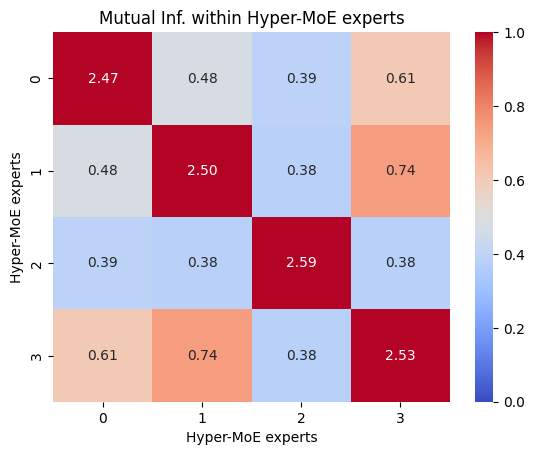

In [69]:
hypermoe_intra_mi = np.zeros((4,4))
for i in range(4):
    for j in range(4):
        hypermoe_intra_mi[i][j] = compute_mutual_information(hypermoe_expert_params[i].flatten(), hypermoe_expert_params[j].flatten()) 

sns.heatmap(hypermoe_intra_mi, annot=True, fmt=".2f", cmap="coolwarm", vmin=0, vmax=1, center=0.5)
plt.ylabel("Hyper-MoE experts")
plt.xlabel("Hyper-MoE experts")
plt.title("Mutual Inf. within Hyper-MoE experts")
plt.show()

=> In general, Hyper-MoE experts convey little information about their features to each other (w.r.t that conveyed by normal MoE experts among themselves).

=> But, in comparison to other Hyper-MoE experts, more info is obtained about expert_1 through expert_3.
i.e., experts 1 & 3 of Hyper-MoE share more information than the others.

Information is shared in more amounts, but also more uniformly in normal MoEs => more homogeneous. Hyper-MoEs share less information less uniformly => more heterogeneous => better specialisation?


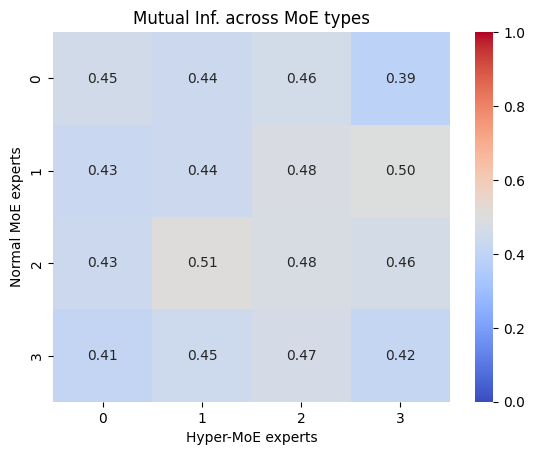

In [68]:
inter_mi = np.zeros((4, 4))
for i in range(4):
    for j in range(4):
        inter_mi[i][j] = compute_mutual_information(
            moe_expert_params[i].flatten(),
            hypermoe_expert_params[j].flatten()
        )

sns.heatmap(inter_mi, annot=True, fmt=".2f", cmap="coolwarm", vmin=0, vmax=1, center=0.5)
plt.ylabel("Normal MoE experts")
plt.xlabel("Hyper-MoE experts")
plt.title("Mutual Inf. across MoE types")
plt.show()

No discernable relationship between experts of the two types. Can't say which experts specialise in roughly the same aspects or which experts specialise better from this. Previous figure is more informative.